In [1]:
import pandas as pd
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from metrics import metrics
from matplotlib import pyplot as plt

In [2]:
RS = 42

## Random Forest

Выяснили:
1. Отношение сплита тренировочных данных особо на результат не влияет, то есть неравномерности в выборке нет.
2. Удаление коррелирующих параметров сильно на результат не влияет, только на скорость обучения. Разве что если удалить много параметров, показатели сильно ухудшаются.
3. Андерсэмплинг датасета чуть лучше чем балансировка весов, но с балансировкой есть возможность увеличить recall.

### 1. Разбиение данных

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     12283
           1       0.48      0.88      0.62       714

    accuracy                           0.94     12997
   macro avg       0.74      0.91      0.79     12997
weighted avg       0.96      0.94      0.95     12997



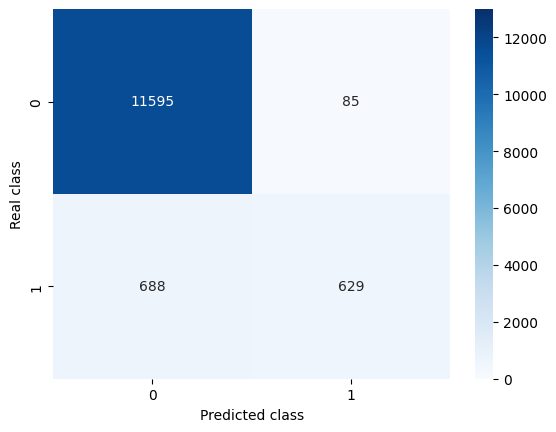

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     18449
           1       0.47      0.87      0.61      1047

    accuracy                           0.94     19496
   macro avg       0.73      0.90      0.79     19496
weighted avg       0.96      0.94      0.95     19496



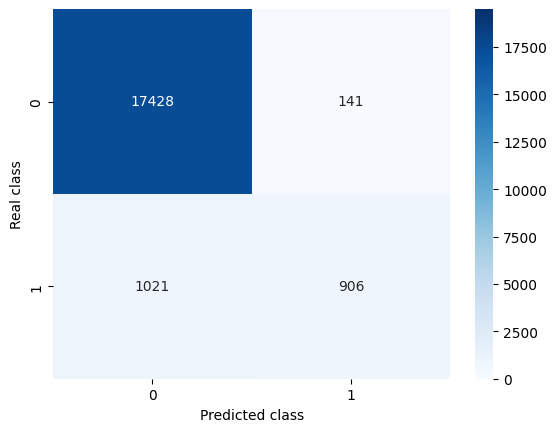

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     12218
           1       0.51      0.85      0.64       779

    accuracy                           0.94     12997
   macro avg       0.75      0.90      0.80     12997
weighted avg       0.96      0.94      0.95     12997



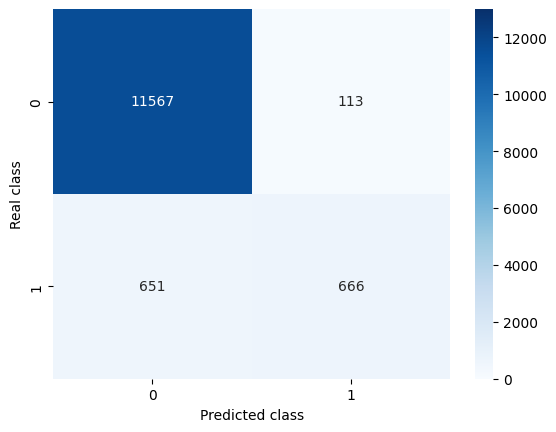

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     18361
           1       0.49      0.86      0.62      1135

    accuracy                           0.94     19496
   macro avg       0.74      0.90      0.80     19496
weighted avg       0.96      0.94      0.95     19496



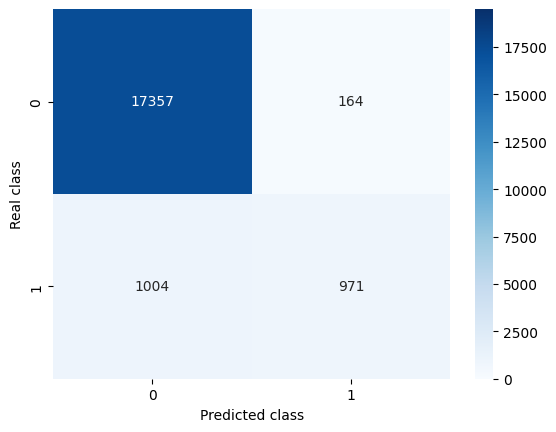

In [3]:
data = pd.read_csv("../data/whole_data.csv").iloc[:, 3:].drop("type", axis=1).dropna()

features, labels = data.drop("present", axis=1), data["present"]

splits = [train_test_split(features, labels, random_state=RS, train_size=0.8),
          train_test_split(features, labels, random_state=RS, train_size=0.7),
          train_test_split(features, labels, random_state=RS, train_size=0.8, stratify=labels),
          train_test_split(features, labels, random_state=RS, train_size=0.7, stratify=labels)]

for sp in splits:
  clf = RandomForestClassifier(n_jobs=-1)
  clf.fit(sp[0], sp[2])
  metrics(clf.predict(sp[1]), sp[3])

**Recall** показывает насколько много в определенных как переменные переменных.

**Precision** показывает насколько много переменных звезд мы не упустили.

### 2. Undersmapling vs balanced

In [4]:
X, x, Y, y = train_test_split(features, labels, random_state=RS, train_size=0.8)

classes = Y.unique()
weights = [compute_class_weight('balanced', classes=classes, y=Y)]
weights

[array([0.55636772, 4.93516233])]

With weight [0.55636772 4.93516233]
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     12308
           1       0.46      0.88      0.61       689

    accuracy                           0.94     12997
   macro avg       0.73      0.91      0.79     12997
weighted avg       0.96      0.94      0.95     12997



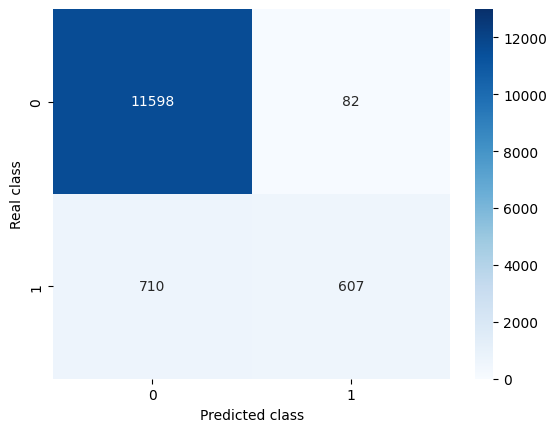

With weight [1, 20]
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     12345
           1       0.44      0.88      0.58       652

    accuracy                           0.94     12997
   macro avg       0.71      0.91      0.77     12997
weighted avg       0.97      0.94      0.95     12997



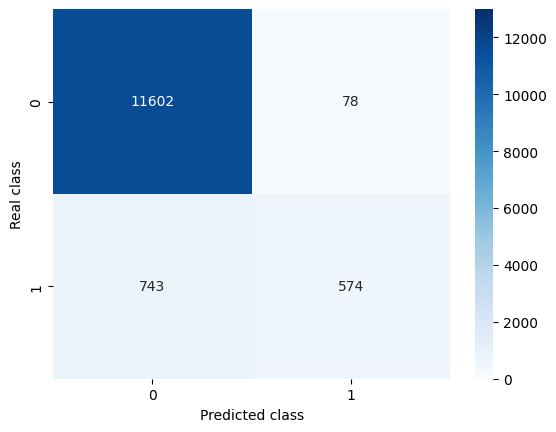

With weight [1, 30]
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     12353
           1       0.44      0.89      0.59       644

    accuracy                           0.94     12997
   macro avg       0.72      0.92      0.78     12997
weighted avg       0.97      0.94      0.95     12997



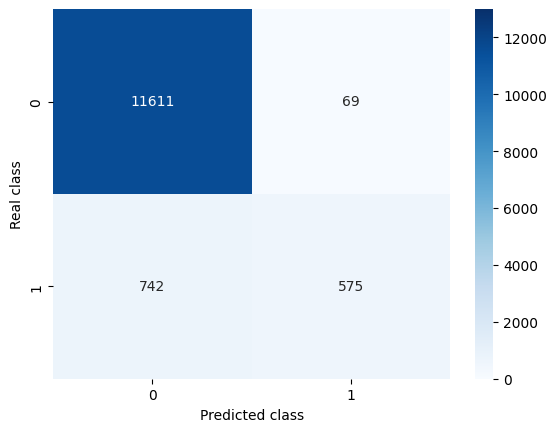

With weight [1, 60]
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     12378
           1       0.42      0.90      0.57       619

    accuracy                           0.94     12997
   macro avg       0.71      0.92      0.77     12997
weighted avg       0.97      0.94      0.95     12997



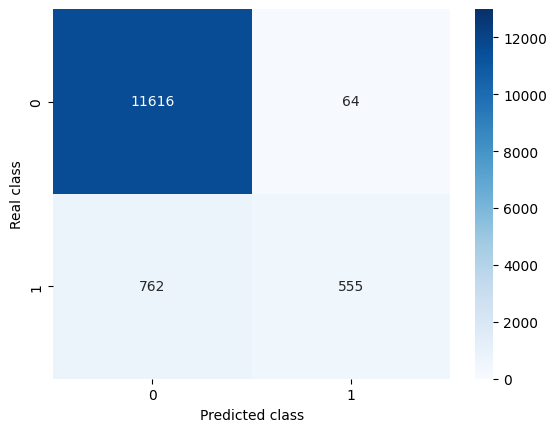

In [5]:
weights += [[1, 20], [1, 30], [1, 60]]

# в декоратор бы это все)
draw_data = []
for w in weights:
  clf = RandomForestClassifier(class_weight=dict(zip(classes, w)), n_jobs=-1)
  clf.fit(X, Y)
  print(f"With weight {w}")
  draw_data.append(metrics(clf.predict(x), y))
  draw_data[-1]["weights"] = round(w[1] / w[0], 2)

Видно, что веса особо эффекта не приносят

<Axes: xlabel='weights'>

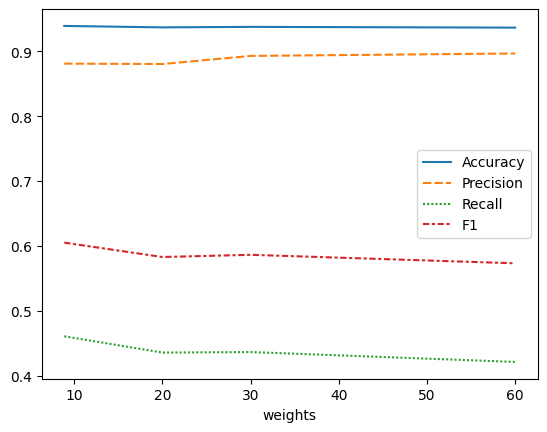

In [6]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["weights"])
sns.lineplot(draw_df)

Try different split ratios for undersampling training

Undersmapling with ratio 1/1
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     10214
           1       0.96      0.45      0.61      2783

    accuracy                           0.88     12997
   macro avg       0.91      0.72      0.77     12997
weighted avg       0.89      0.88      0.86     12997



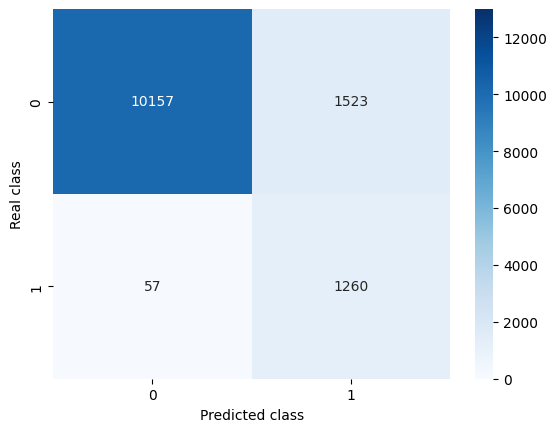

Undersmapling with ratio 1/2
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     11093
           1       0.87      0.60      0.71      1904

    accuracy                           0.93     12997
   macro avg       0.90      0.79      0.83     12997
weighted avg       0.93      0.93      0.92     12997



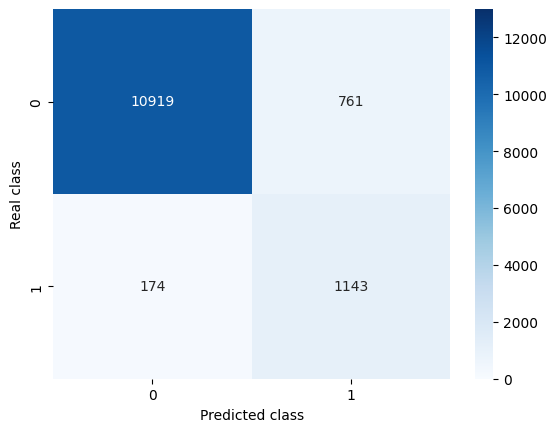

Undersmapling with ratio 1/3
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11490
           1       0.79      0.69      0.73      1507

    accuracy                           0.94     12997
   macro avg       0.87      0.83      0.85     12997
weighted avg       0.94      0.94      0.94     12997



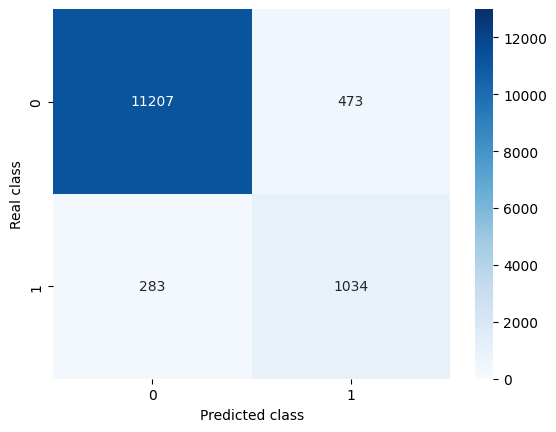

Undersmapling with ratio 1/4
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     11752
           1       0.70      0.74      0.72      1245

    accuracy                           0.95     12997
   macro avg       0.84      0.85      0.85     12997
weighted avg       0.95      0.95      0.95     12997



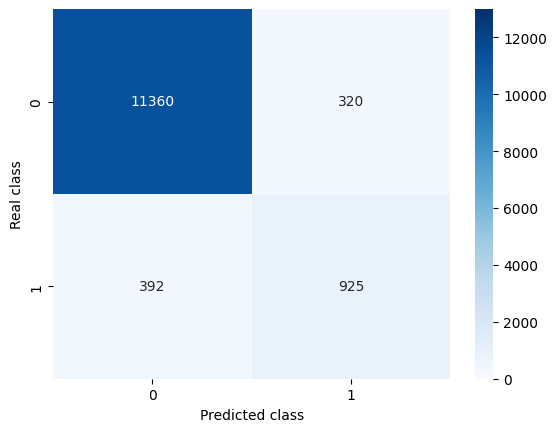

In [7]:
N = Y[Y == 1].size  # number of variable stars
new_train = pd.concat([X, Y], axis=1)

draw_data = []
for r in [1, 2, 3, 4]:
  _temp = pd.concat([new_train[new_train.present == 0].sample(N * r),
                     new_train[new_train.present == 1].sample(N)])
  X, Y = _temp.drop("present", axis=1), _temp["present"]
  clf = RandomForestClassifier(n_jobs=-1)
  clf.fit(X, Y)
  print(f"Undersmapling with ratio 1/{r}")
  draw_data.append(metrics(clf.predict(x), y))
  draw_data[-1]["ratio"] = r

<Axes: xlabel='ratio'>

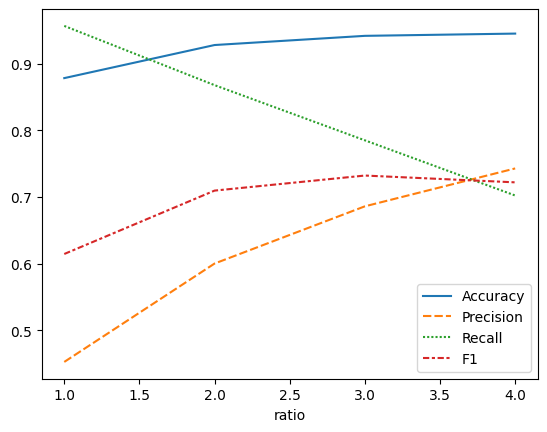

In [8]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["ratio"])
sns.lineplot(draw_df)

### Hyperparameter tuning

Будем тренировать не с балансировкой, а с меньшим датасетом, так как он показывает результаты получше. Ну может это и странно, что я опираюсь на результаты для теста, надо потом проверить с другим рандомным состоянием.

Балансировку выберем не 1/1, опять же по тесту, видимо есть золотая середина между размером выборки и ее сбалансированностью.

In [9]:
_temp = pd.concat([new_train[new_train.present == 0].sample(N * 3),
                     new_train[new_train.present == 1].sample(N)])
X, Y = _temp.drop("present", axis=1), _temp["present"]

In [10]:
params = {
  "n_estimators": [100, 300, 500],
  "max_depth": [8, 16, 32],  # FIXME: maybe too deep??
  # "min_samples_leaf" minimum samples from dataset for a node
  # "min_samples_split": [],  let's say we don't need simple trees, but overfitting?
  "n_jobs": [-1]
}

clf = GridSearchCV(RandomForestClassifier(), params)
clf.fit(X, Y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 16, 32],
                         'n_estimators': [100, 300, 500], 'n_jobs': [-1]})

Этот результат более надежный, так как модели при тренировке проходили кросс-валидацию, значит мы, условно, не подбирали параметры по тестовой выборке.

Матрица стала намного лучше, теперь отношение True positive и False negative гораздо удобоваримее.

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11485
           1       0.79      0.69      0.73      1512

    accuracy                           0.94     12997
   macro avg       0.87      0.83      0.85     12997
weighted avg       0.94      0.94      0.94     12997



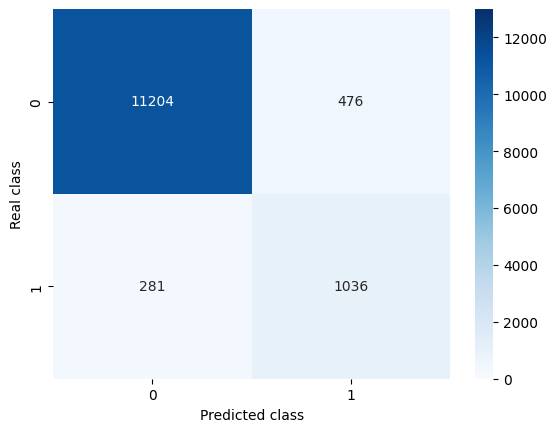

In [11]:
metrics(clf.best_estimator_.predict(x), y, to_return=False)

### Combine high recall and high precision

In [12]:
_temp = pd.concat([new_train[new_train.present == 0].sample(N * 3),
                   new_train[new_train.present == 1].sample(N)])
X, Y = _temp.drop("present", axis=1), _temp["present"]

In [13]:
params = {
    "n_estimators": [100],
    "class_weight": [{1: 10}, {1: 20}, {1: 40}],  # high penalty for false positive
    "max_depth": [8, 16, 32],
}
rf_precision = GridSearchCV(RandomForestClassifier(
), params, scoring='precision', n_jobs=-1).fit(X, Y).best_estimator_
rf_precision

RandomForestClassifier(class_weight={1: 10}, max_depth=32)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     11562
           1       0.75      0.69      0.72      1435

    accuracy                           0.94     12997
   macro avg       0.86      0.83      0.84     12997
weighted avg       0.94      0.94      0.94     12997



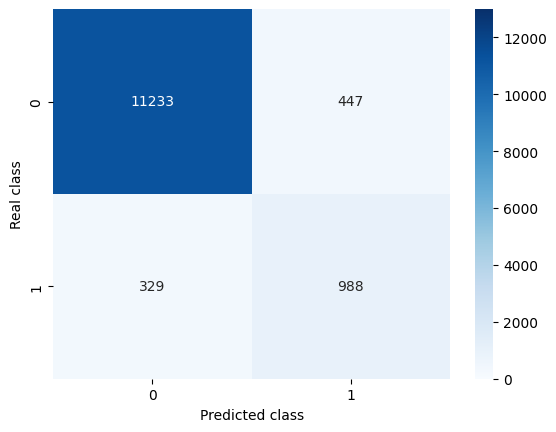

In [14]:
metrics(rf_precision.predict(x), y, to_return=False)

In [15]:
params = {
    "n_estimators": [200],
    "class_weight": [{0: 10}, {0: 20}, {0: 40}],  # high penalty for FN
    "max_depth": [8, 16]
}
rf_recall = GridSearchCV(RandomForestClassifier(
), params, scoring='recall', n_jobs=-1).fit(X, Y).best_estimator_
rf_recall

RandomForestClassifier(class_weight={0: 10}, max_depth=16, n_estimators=200)

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     12257
           1       0.43      0.76      0.55       740

    accuracy                           0.93     12997
   macro avg       0.71      0.85      0.75     12997
weighted avg       0.95      0.93      0.94     12997



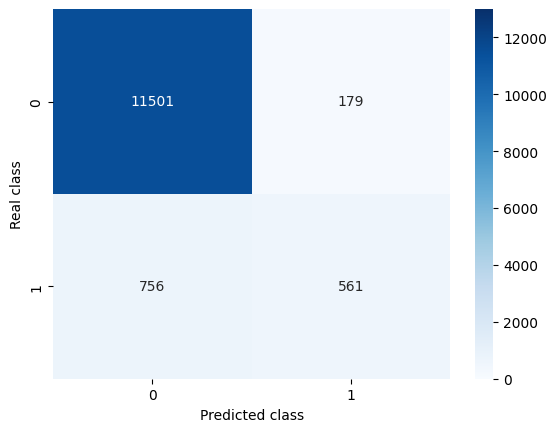

In [16]:
metrics(rf_recall.predict(x), y, to_return=False)

In [17]:
ensemble = VotingClassifier(
    estimators=[
        ('precision_model', RandomForestClassifier(class_weight={1: 10}, max_depth=16, n_estimators=200)),
        ('recall_model', RandomForestClassifier(class_weight={0: 10}, max_depth=16, n_estimators=200))
    ],
    voting='hard'  # just majority vote
)

ensemble.fit(X, Y)

VotingClassifier(estimators=[('precision_model',
                              RandomForestClassifier(class_weight={1: 10},
                                                     max_depth=16,
                                                     n_estimators=200)),
                             ('recall_model',
                              RandomForestClassifier(class_weight={0: 10},
                                                     max_depth=16,
                                                     n_estimators=200))])

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     12312
           1       0.41      0.79      0.54       685

    accuracy                           0.93     12997
   macro avg       0.70      0.86      0.75     12997
weighted avg       0.96      0.93      0.94     12997



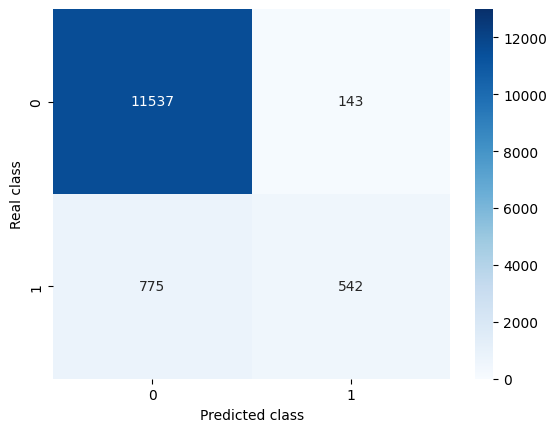

In [18]:
metrics(ensemble.predict(x), y, to_return=False)